# Laymanz Notebooks: Diffusion Models
Author: Ambrose Ling

**What is this notebook about?**

In this notebook, we will go over some of the most fundamental ideas behind diffusion models, how they work and why they have been a major advancement in the field of computer vision and generative artifical intelligence. We hope that you can walk away capable of building your own diffusion model from scratch and understanding some of the core ideas that are trending in this field of research.

**What do I need to set up my environment?**

All of our notebooks will only use numpy, pytorch, matplotlib for visualizations. We will not use any other third-party libraries for model development, optimization or anything like that.

**How is this notebook structured?**
1.
2.
3.


**Covered papers in this notebook**
* Denoising Diffusion Probabilistic Models (DDPM)
* Denoising Diffusion Implicit Models (DDIM)
*

(will do after finishing)

In [ ]:
# Lets import all the necessary packages
import torchvision # for handling image data within the PyTorch ecosystem.
from torchvision.transforms.functional import pil_to_tensor, to_pil_image # to convert images to PyTorch tensors and vice versa.
import torch # main PyTorch library for tensor operations and neural network modules.
import numpy as np # library for numerical operations with support for large, multi-dimensional arrays and matrices.
import ipywidgets as widgets # for creating interactive UI elements in Jupyter notebooks.
from ipywidgets import interact # a function to create interactive controls for Jupyter notebooks.

# Overview of Diffusion models

**What are diffusion models?**

If you have ever used DALLE from OpenAI or Stable Diffusion. It lets you type in a text prompt and it tries to **generate** an image that suits your liking. But have you ever wondered what happens when you press generate ? (You probably have or you wouldn't be reading this lol)

These generative artificial intelligence applications rely on diffusion models. The idea of diffusion models originally came from non-equilibirum thermodynamics. Diffusion models are also built upon the work of [Variational AutoEncoders](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) as well as [Geneartive Adversarial Networks](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29) (GANs). Both of which have been a main advance in image synthesis and image generation.




# Diffusion Process

Diffusion models define a Markov chain process, where you have a forward and reverse diffusion process.

<center>
<a href="https://ibb.co/Kw77Vny"><img src="https://i.ibb.co/DpkkwdK/Screenshot-2024-05-06-005141.png" alt="Screenshot-2024-05-06-005141" border="0"></a>
</center>  

Let's assume we have a dataset of images. In this notebook we will use the CIFAR-10 (Canadian Institute for Advanced Research) dataset, which has 50k images that belong to 10 classes of size 32 x 32. With that, we can construct an arbitrary data distribution that we call $p(x)$.

And lets say we sample an image from this distribution and we call this image $x$.

In [ ]:
dataset = torchvision.datasets.CIFAR10(root="/content/sample_data",download=True)
print(len(dataset)) #See the length of the dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 77117082.48it/s]


Extracting /content/sample_data/cifar-10-python.tar.gz to /content/sample_data
50000


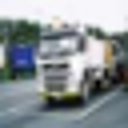

This is an image of a truck!


In [ ]:
# Lets look at one of the images from the dataset. Ooooo looks like a yacht!
# (class label says ship but same thing), you can also pick any
i = 1000
x = (dataset[i][0].resize((128,128)))
display(x)
print(f"This is an image of a {dataset.classes[dataset[i][1]]}!")

## Forward Process

**What is the forward process?**

In the forward process (we denote the forward process as **$q$**), each step in the markov chain indicates us adding Gaussian noise to the original image or signal. We repeat this process of adding noise **iteratively** until we reach pure isotropic Gaussian noise. For example if I had 1000 forward steps, I would add noise to my original signal 1000 times iteratively.

[![Foo](https://www.assemblyai.com/blog/content/images/2022/05/image.png)](http://google.com.au/)

<center>Figure from <a href="https://arxiv.org/pdf/2006.11239">DDPM paper</a>
</center>

There are 3 different ways to think aout the forward diffusion process:


1. We can think about the forward process as a **linear combination** of the signal and the noise (we can do this because of the reparametrization trick):
$$
x_t = \alpha_t x_{t-1} + \sigma_t \epsilon
$$

* $x_t$ : represents the signal after one forward step
* $x_{t-1}$ : represents the signal from the previous timestep along the Markov chain
*   $\alpha_t$ coefficient: the portion of the signal we want to preserve **at timestep $t$**
*   $\sigma_t$ coefficient: the portion of noise we want to add to the signal **at timestep $t$**
* $\epsilon$ : represents the noise vector sampled from a Gaussian Distribution



2.  We can also think about the forward process is in terms of **probability distributions**.



**In probability form, the forward diffusion process is:**
$$
q(x_{1:T}) = \Pi_{t=1}^{T} q(x_t,x_{t-1})
$$
We can expand this as:
$$
q(x_{1:T}|x_0) =  q(x_T|x_{T-1})\cdots q(x_3|x_2)q(x_2|x_1)q(x_1|x_0)
$$

In the next code blocks you will see that we can derive a closed form expression that lets us directly go from $x_0$ to $x_t$.
$$
q(x_t|x_0) = \mathcal{N}(x_t,\sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t})I)
$$
In layman terms, we input $x_0$ into the forward process $q$ and retrieve $x_t$
such that $x_t$ is a Gaussian distribution with mean $\sqrt{\bar{\alpha_t}}$ and variance
$(1-\bar{\alpha_t})$. So $x_t$ is conditioned on $x_0$


3. **What if we went beyond 1000 steps, take it to infinity?** The diffusion process becomes continous, and we can also think about the forward process as a stochastic differential equation (SDE). It is stochastic due to the $w$ Wiener process term, which represents Brownian motion.

$$
dx = f(x,t)dt + g(t)dw
$$

* dx is the differential equation that describes the change of the signal (or image) across time
* $f(⋅,t):R^d → R^d$: is a vector valued function called the drift coefficient (similar to signal coefficient)
* $g(⋅): R → R$: is a scalar function known as the diffusion coefficient of $x(t)$





In [ ]:
# Helper functions: Lets make some normalization functions
# these functions normalize the images to have pixel values between -.5 to .5

norm = lambda x:((x.float() + 255)/510) -0.5         # Function to normalize image tensor values to range [-0.5, 0.5]
denorm = lambda x: ((x+0.5)*510-255).to(torch.uint8) # Function to denormalize image tensor values back to the original range [0, 255]

# What if we try simulating the forward process?
x_0 = norm(pil_to_tensor(x)) # take the image, turn it into a tensor and normalize it
noise = torch.randn(128,128) # lets sample some noise from a gaussian distribution

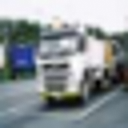

In [ ]:
# For our 1st iteration of forward diffusion,
# lets say I want the image to be 99.99% original image, 0.01% noise
α_1  = 0.9999 # α_t=1
σ_1 = 0.0001 # σ_t=1
x_1 = α_1*x_0 + σ_1*noise
display(to_pil_image(denorm(x_1)))

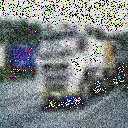

In [ ]:
# For our 2nd iteration of, we take x_1 (the one we just added noise to)
# and apply another forward step, so x_t-1 = x_1
α_2 = 0.95 # α_t=2
σ_2 = 0.05 # σ_t=2
x_2 = α_2*x_1 + σ_2*noise
display(to_pil_image(denorm(x_2)))

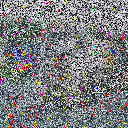

In [ ]:
# For our 3rd iteration, we take x_2 and apply another forward step (*)
α_3 = 0.91 # α_t=3
σ_3 = 0.09 # σ_t=3
x_3 = α_3*x_2 + σ_3*noise
display(to_pil_image(denorm(x_3)))

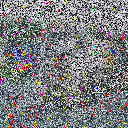

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [ ]:
# Realization💡: wait so can we rewrite x_3 in terms of x_0?
# Yes we can actually!

alpha_1  = 0.9999 # alpha_t=1
sigma_1 = 0.0001 # sigma_t=1
alpha_2 = 0.95 # alpha_t=2
sigma_2 = 0.05 # sigma_t=2
alpha_3 = 0.91 # alpha_t=3
sigma_3 = 0.09 # sigma_t=3

x_3 = alpha_3 * ( alpha_2 * (alpha_1 * x_0 + sigma_1 * noise) + sigma_2 * noise) + sigma_3* noise
x_3 = alpha_3 * ( alpha_2 * alpha_1 * x_0 + alpha_2 * sigma_1 * noise + sigma_2 * noise) + sigma_3* noise
x_3 = alpha_3 * alpha_2 * alpha_1 * x_0 + alpha_3 * alpha_2 * sigma_1 * noise + alpha_3 * sigma_2 * noise + sigma_3* noise

total_noise = alpha_3 * alpha_2 * sigma_1 * noise + alpha_3 * sigma_2 * noise + sigma_3* noise
total_noise = noise * (alpha_3 * alpha_2 * sigma_1 + alpha_3 * sigma_2 + sigma_3)
#                     |---------------------------------------------------------|


# If we do some simplification on this noise coefficient...
# alpha_3 * alpha_2 * (1 - alpha_1) + (alpha_3 * (1 - alpha_2) + (1 - alpha_3) )
# (alpha_3 * alpha_2) - (alpha_3 * alpha_2 * alpha_1) + alpha_3 - (alpha_3 * alpha_2) + 1 - alpha_3
# 1 - (alpha_3 * alpha_2 * alpha_1) [Hey we didnt need any sigma terms !]

# From this we can directly uses x_0 to get to x_3
x_3 = alpha_3 * alpha_2 * alpha_1 * x_0 + (1 - (alpha_3 * alpha_2 * alpha_1))*noise
display(to_pil_image(denorm(x_3)))

# Lets just check that they are the same with the iterative version using x_t-1 (*)
np.isclose(alpha_3*x_2 + sigma_3*noise,x_3)

In [ ]:
# Practice:
# try applying 2 more denoising steps to x_3, see what you notice as you do so
# and feel free to experiment with the alphas and sigmas values

**Why do we want to rewrite the forward process in terms of $x_0$?**

We can rewrite this Markov chain process by directly reparametrizing it to $x_0$
such that we can get to any forward step $t$ using $x_0$. Running the forward process **step by step** isnt needed, because it is the same as multiplying a coefficient in front of $x_0$ and $\epsilon$.

**1. When we use the intermediate form of the forward process:**

**In reparametrized form (using reparametrization trick)**
$$
x_t = \alpha_t x_{t-1} + (1 - {\alpha_t}) \epsilon
$$

**In probability form**
$$
q(x_t,x_{t-1}) = \mathcal{N}(x_t;{\alpha_t}x_{t-1};(1 - {\alpha_t})I)
$$




From our derivation earlier, we were able to go from the intermediate (step-by-step) form to the closed form (straight from x_0 to x_t).

**2. When we use the closed form of the forward process:**

**In reparametrized form (using reparametrization trick)**
$$
x_t = \bar{\alpha_t} x_0 + (1 - \bar{\alpha_t}) \epsilon
$$

**In probability form**
$$
q(x_t,x_0) = \mathcal{N}(x_t;\bar{\alpha_t}x_0;(1 - \bar{\alpha_t})I)
$$

**NOTE**:

Though this is the derived general form, the authors of DDPM square rooted both coefficients of $x_0$ and $\epsilon$. Hence the **true** general form is:

$$
x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{(1 - \bar{\alpha_t})} \epsilon
$$


* $\bar{\alpha_t} = Π_{s=1}^{t} \alpha_s$
* $\alpha_t = 1 - \beta_t$ (In the DDPM paper, they defined $\beta_t$ as the noise schedule)


**Why do we square root it?**

Ambrose's Intuition:
Applying a square root operation slows down the rate at which $\bar{\alpha_t}$ and $1 - \bar{\alpha_t}$ grows. Hence the introduction of noise is not such a rapid process and helps ensure stability.

In [ ]:
# So if we do what we did just now to x_0 enough times, and the
# signal coefficient approaches 0, our x_t gradually approaches
# complete noise or a pure Gaussian distribution

# Lets try to write the general form of the forward under the DDPM setting:
betas =  torch.linspace(0.0000000025,0.000144,1000)

# Rmb alphas is the signal coefficient so it decreases as t increases:
alphas = 1 - betas

# To use the general form, we need to be able to calculate the signal:
# coefficients in one go:
# [alpha0 , alpha0 * alpha1, alpha0 * alpha1 * alpha2, ....]
alphas_bar = torch.cumprod(alphas,0)

# To get the coefficients for the noise:
# [1 - alpha0 , 1 - alpha0 * alpha1, 1 - alpha0 * alpha1 * alpha2, ....]
one_minus_alphas_bar = 1 - alphas_bar

# We apply the sqrt for stability:
sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(one_minus_alphas_bar)

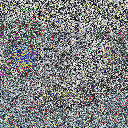

In [ ]:
# Play around with the timestep slider, what do you notice 👀?
def forward(timestep:int):
  '''
  Runs the forward diffusion process and returns the noise-injected signal
  at time t
  '''
  x_t = sqrt_alphas_bar[timestep] * x_0 + sqrt_one_minus_alphas_bar[timestep] * noise
  display(to_pil_image(denorm(x_t)))

interact(forward,timestep=widgets.IntSlider(min=0,max=999,step=1,value=20))

# You should see that as you increase the timestep, there is more and more
# noise being injected into the original signal, gradually turning into a full
# isotrophic Gaussian at timestep 999

### What is the reparametrization trick?

The reparametrization trick is a tech

### How do you differentiate through an expectation?
Let's say that we want to take the gradient w.r.t $\theta$ of the following expectation., so the function $f$ is parametrized by $\theta$
$$
E_{p(z)}[f_{\theta}(z)]
$$
* $E$ is the expectation function where $E[x] = \int p(x) x dx$
* $p$ is the probability density function

<center>
<img src="https://leimao.github.io/images/blog/2024-05-08-Reparameterization-Trick/reparameterization-trick.png" width=600 height=400/>
</center>

## Reverse Process

In the reverse process (we denote the reverse process as **$p$**), we want to structurally remove noise until we uncover the original data distribution. The reverse process is also called the **sampling or generation or denoising process**, and the method we use to perform the sampling is called the **sampler**. There have been many many sampling methods being developed to improve diffusion models, this notebook will cover some of the most popular ones.

We start at $p(x_T) \sim \mathcal{N}(x_T,0,I)$, and sample a noisy signal $x_T$.
In order to reverse the process, we need to obtain the reverse Gaussian transitions $q(x_{t-1}|x_t)$. **However...** we cannot directly calculate  $q(x_{t-1}|x_t)$ as it is **intractable**, becuase we need to integrate over the entire dataset to obtain $q(x_{t-1})$ or $q(x_t)$

<center>
<img src="https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png" width=800 height=300></img>
</center>
<center>
Figure
</center>


For these reasons, we attempt to approximate the conditional probability distribution $q(x_{t-1}|x_t)$ with a neural network: $q_{\theta}(x_{t-1}|x_t)$ parametrized by model parameters $\theta$. More specifically:

**In probability form, the reverse process is:**

$$
p_{\theta} = p(x_T)\Pi_{t=1}^{T} p_{\theta}(x_{t-1}|x_t)
$$
We can expand this as: (cuz the authors were lazy)
$$
p_{\theta}(x_{0:T}) = p_{\theta}(x_{0}|x_1)p_{\theta}(x_{1}|x_2)p_{\theta}(x_{2}|x_3)p_{\theta}(x_{3}|x_4)p_{\theta}(x_{4}|x_5)\cdots p(x_T)
$$

**where the reverse conditional probabilities are:**
$$
p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1},\mu_\theta(x_t,t),\Sigma_\theta(x_t,t))
$$


Given the signal $x_t$ that is at timestep $t$ of the Markov chain, we wish to use a neural network to predict $x_{t-1}$ that has mean $\mu_\theta$ and the variance $\Sigma_\theta$. (We are essentially predicting the conditional probability of $x_{t-1}$ given $x_t$)

**How do we predict $\mu_\theta$ and $\Sigma_\theta$?**

1. Condition the reverse conditional probability $q_\theta(x_{t-1}|x_t)$ on $x_0$

<a href="https://ibb.co/Htwm7fL"><img src="https://i.ibb.co/QPSs937/Screenshot-2024-06-05-at-12-07-14-AM.png" alt="Screenshot-2024-06-05-at-12-07-14-AM" border="0"></a><br /><a target='_blank' href='https://imgbb.com/'>upload photos and share link</a><br />

**Why do we condition it ? To make it tractable**

2. Simplify to obtain $\tilde{\mu_t}$ (this is the thing we are trying to predict)

<a href="https://ibb.co/DVr3F1p"><img src="https://i.ibb.co/3rRtbTz/Screenshot-2024-06-05-at-12-07-22-AM.png" alt="Screenshot-2024-06-05-at-12-07-22-AM" border="0"></a>

**Long story short:**
* The ground truth reverse conditional probability is $q(x_{t-1}|x_t,x_0) = \mathcal{N}(x_{t-1};\tilde{\mu}(x_t,x_0),\tilde{\beta}_tI)$

* By conditioning on $x_0$, it allows us to simplify with Bayes rule such that:
    - GT Mean of each transition probability is: $\tilde{\mu_t} = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha_t}}x_t + \frac{\sqrt{\bar{\alpha_{t-1}}}\beta_t}{1 - \bar{\alpha_t}}x_0$
    - GT Variance of each transition probability is: $\tilde{\beta}_t = \sigma_t^2  = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha_t}}\beta_t$
* So at this stage we **establish** our training targets $\tilde{\mu}_t$ and $\tilde{\beta}_t$

### Markovian Process

A process $\{X_t, t \in T\}$  is Markovian if for any time $t$ and future time $s \gt t$:

$$
P(X_s | X_t,X_{t-1},\cdots,X_0) = P(X_s | X_t)
$$

This means that the conditional probability distribution of future states $X_s$ depends only on the present state $X_t$ and not on how the process arrived at $X_t$.

### Non-Markovian Process

A process $\{Y_t, t \in T\}$ is non-Markovian if for some time $t$ and future time $s \gt t$:

$$
P(X_s | X_t,X_{t-1},\cdots,X_0) \neq P(X_s | X_t)
$$

This implies that the future state \( Y_s \) is influenced by the sequence of past states $Y_{t-1},\cdots,Y_0$ in addition to the present state $Y_t$.

### Sampler : Denoising Diffusion Probabilistic Models (Langevin Dynamic Sampling)

Langevin dynamics is an idea from physics used to model molecular systems.
It was first introduced to descirbe the motion of systems that experience a particular type of random force. Langevin dynamics lets us sample from a complex distribution by using the score function in an **iterative process**. The DDPM paper used this sampling method for the reverse process.

**Goal: we want to know how to sample from a complex distribtution**

The Langevin Equation can be described as follows:
$$
m\ddot{x} = - \lambda \dot{x} + \eta
$$

* m is mass of the particle
* $\lambda$ is damping coefficient
* $\eta$ is Gaussian noise with 0 mean and variance

Lets rewrite the equation in terms of potential energy $V(x)$, so that
we can obtain an SDE:

1. We know that $m\ddot{x} = F = \frac{∂V(x)}{∂x}$

* where $∇V(x) = F$ meaning that the gradient of the potential energy descibes the **force acting on the particle over time**

2. We can describe this process with a **stochastic** differential equation
$$
\lambda \dot{x} = - ∇V(x) + \eta \\
$$
$$
dx = - ∇V(x)dt + \sqrt{2}\sigma dW
$$

* $-\nabla V(x)$ is the drift term
* $\sigma$ is the volatility of the noise being injected
* dW is the time derivative of the standard Weiner process

With this we rewrite the SDE with the target distribution:
$$
dx = \nabla logp(x)dt + \sqrt{2}\sigma dt
$$
We can numerically approximate it with Euler-Maruyama method (extends Eulers method for solving ODEs to SDEs):
$$
x_{t-1} = x_t - \nabla logp(x) \epsilon + \sqrt{2}\sigma \Delta W
$$
* $\nabla logp(x)$ is the gradient of the **target** log probability density function aka score
* $\epsilon$ is the timestep
* $\Delta W$ is random noise sampled from $\mathcal{N}(0,I)$


**$\star$ There is a connection here with Noise-Conditioned Score Networks!!!**
What is the main idea?
* They estimate $\nabla logp(x)$ which is the gradient of the log probability density aka score function with a neural network $s_\theta$, so $s_\theta \approx \nabla logp(x)$
* **Key observation: estimating the score function $s_\theta(x_t,t)$ $=$ predicting the noise $\epsilon_\theta(x_t,t)$**
  - **We know that** the Markov transitions are Gaussian, hence the gradient of the log probability density is:
  $$
  s_\theta(x_t,t) \approx \nabla_{x_t} log q(x_t) = E_{q_{(x_0)}}[\nabla_{x_t}q(x_t|x_0)] = E_{q_{(x_0)}}[- \frac{\epsilon_\theta(x_t,t)}{\sqrt{1 - \bar{\alpha_t}}}] = - \frac{\epsilon_\theta(x_t,t)}{\sqrt{1 - \bar{\alpha_t}}}
  $$




In [ ]:
# Try out Langevin Dynamic Sampling here!
import torch
import torch.distributions as D

eps = 0.01
steps = 500
n_samples = 10000

# d/dx -log p(x) for N(0, 1)
force = lambda x: -x

# Prior distribution from which the initial positions are sampled
prior = D.Uniform(torch.Tensor([-10, -10]), torch.Tensor([10, 10]))

# Run Langevin Dynamics
x = prior.sample((n_samples, ))
for i in range(steps):
    x = x + eps * force(x) + torch.sqrt(2 * eps) * torch.randn(size=x.shape)

x.mean().item(), x.std().item()
# >>> something close to (0.0, 1.0)

In [ ]:
#Lets try to code a simplified version of the DDPM sampler:

# What do we need?



class DDPM_scheduler:
  def __init__(self,diffusion_timesteps):
    self.diffusion_timesteps = diffusion_timesteps
    self.beta =  torch.linspace(0.0000000025,0.000144,1000)
    self.alpha = 1 - self.beta
    self.alphas_bar = torch.cumprod(alphas,0)
    self.one_minus_alphas_bar = 1 - alphas_bar

  def step(
      self,
      pred_noise:torch.Tensor, # output from the noise-prediction model (U-Net)
      t: int, # the current denoising timestep
      x_t:torch.Tensor, # current sample
  ):
    '''
    '''

    # Step 1: Get the previous timestep (in DDPM, inference timesteps = training timesteps so t_prev = t -1)
    t_prev = t - self.inference_timeteps // self.training_timesteps

    # Step 2: compute all the necessary noise schedule constants (alphas, betas, alpha prods, beta prods)
    alpha_t = self.alphas[t]
    beta_t = self.betas[t]
    alpha_prod_t = self.alphas_bar[t]
    alpha_prod_t_prev = self.alphas_bar[t-1] if t >=0 else torch
    beta_prod_t = 1 - self.alphas_bar[t]

    # Step 3: compute pred_x0, that is needed in equation 15 of DDPM paper
    pred_x0 = (x_t - beta_prod_t ** -0.5 * pred_noise) / alpha_prod_t **0.5
    #NOTE: in this step we are essentially rearranging for x0 from the forward
    # diffusion formula: x0 * alpha_prod_t **0.5 + beta_prod_t ** -0.5 * noise = x_t
    #                    |-----signal-----------|  |-------noise--------------|


    # Step 4: Compute one backward step (Langevin Dynamic Sampling),
    #         correspond to line 4 in Algorithm 2 of DDPM paper
    pred_x0_coeff = (alpha_prod_t_prev ** (0.5) * beta_t) / beta_prod_t
    xt_coeff = alpha_t ** 0.5 * beta_t


    # Step 5: get the variance we want to add to the model
    variance = torch.randn(pred_noise.shape)
    pred_xt_prev = pred_x0_coeff * pred_x0 + xt_coeff * x_t
    pred_xt_prev = pred_xt_prev + variance
    return pred_xt_prev


### Sampler: Denoising Diffusion Implicit Models

The DDIM sampler is a non-Markovian method to reduce the number of sampling steps, such that the sampling process is deterministic rather than stochastic
and where there is a direct mapping between noise and data throughout the diffusion trajectory.

**Goal:** we want to find another way to formulate $q_\sigma(x_{t-1}|x_t,x_0)$

**NOTE:** the true $q(x_{t-1}|x_t,x_0) = \mathcal{N}(x_{t-1};\tilde{\mu}(x_t,x_0);\tilde{\beta_t}I)$

We see that first of all, to get $x_t$:
$$
x_t = \sqrt{\bar{\alpha_{t}}} x_0 + \sqrt{1 - \bar{\alpha_{t}}} \epsilon_t
$$
Hence for $x_{t-1}$:
$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1 - \bar{\alpha}_{t-1}}\epsilon_{t-1}
$$

We can also write it as:
$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} x_0 + \sqrt{1 - \bar{\alpha}_{t-1}-\sigma_t^2}\epsilon_t + \sigma_t\epsilon_{t}
$$
We take out $\sqrt{\bar{\alpha}_{t-1}}$ and sub in the forward process of $x_0$:
$$
x_{t-1} = \sqrt{\bar{\alpha}_{t-1}} (\frac{x_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_\theta(x_t)}{\sqrt{\bar{\alpha}_t}})+ \sqrt{1 - \bar{\alpha}_{t-1}-\sigma_t^2}\epsilon_t + \sigma_t\epsilon_{t}
$$
Then we can rewrite this in terms of Gaussian Distribution:
$$
q_\sigma(x_{t-1}|x_t,x_0)= \mathcal{N}(\sqrt{\bar{\alpha}_{t-1}} (\frac{x_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_\theta(x_t)}{\sqrt{\bar{\alpha}_t}})+ \sqrt{1 - \bar{\alpha}_{t-1}-\sigma_t^2}\epsilon_t, \sigma_t^2I)
$$

To further simplify:
$$
q_\sigma(x_{t-1}|x_t,x_0)= \mathcal{N}(x_{t-1};\sqrt{\bar{\alpha}_{t-1}} (\frac{x_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_\theta(x_t)}{\sqrt{\bar{\alpha}_t}})+ \sqrt{1 - \bar{\alpha}_{t-1}-\sigma_t^2}\epsilon_\theta(x_t), \sigma_t^2I)
$$
Hence:
* Predicted $x_0$ at each timestep is: $\frac{x_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_\theta(x_t)}{\sqrt{\bar{\alpha}_t}}$
* Mean of this Gaussian is: $\sqrt{\bar{\alpha}_{t-1}} (\frac{x_t - \sqrt{1 - \bar{\alpha}_t}\epsilon_\theta(x_t)}{\sqrt{\bar{\alpha}_t}})+ \sqrt{1 - \bar{\alpha}_{t-1}-\sigma_t^2}\epsilon_\theta(x_t)$
* Variance of this Gaussian is: $\sigma_t^2 = \tilde{\beta_t} = (1 - \frac{\bar{\alpha}_{t}}{\bar{\alpha}_{t-1}})\beta_t$ **NOTE:** see above reverse process for how we got $\tilde{\beta_t}$.

In [ ]:
class DDIM_scheduler:
    def __init__(self,inference_timesteps,training_timesteps):
        self.inference_timeteps = inference_timesteps
        self.training_timesteps = training_timesteps
        self.beta =  torch.linspace(0.0000000025,0.000144,1000)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha,0)
        self.one_minus_alpha_bar = 1 - self.alpha_bar
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(self.one_minus_alpha_bar)

    def step(
      self,
      pred_noise:torch.Tensor, # output from the noise-prediction model (U-Net)
      t: int, # the current denoising timestep
      x_t:torch.Tensor):
        
        # Get all necessary constants
        alpha_t = self.alpha[t]
        beta_t = self.beta[t]
        alpha_prod_t = self.alpha_bar[t]
        alpha_prod_t_prev = self.alphas_bar[t-1] if t >=0 else torch.ones(1)
        beta_prod_t = 1 - self.alpha_bar[t]
        beta_prod_t_prev = 1 - self.alpha_bar_prev[t]
        sqrt_alpha_bar = self.sqrt_alpha_bar[t]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t]
        eta = 0
        # Obtain the correct timestep
        prev_timestep = t - self.inference_timeteps // self.training_timesteps

        # Get pred_x0
        pred_x0 = x_t - pred_noise * sqrt_one_minus_alpha_bar **0.5 / sqrt_alpha_bar

        # Compute the variance (tilde_beta_t)
        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)

        # Compute the standard deviation (std_dev or sigma_t) NOTE: eta is kind of like the paramter to introduce random noise or not)
        # in DDIM setting, eta is 0 since sampling is deterministic, no noise injection
        # NOTE: std_dev = σt = sqrt(variance) = sqrt(tilde_beta_t)
        std_dev_t = eta * variance ** 0.5

        # Compute "direction pointing to x_t" of formula 
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2)**0.5 * pred_noise

        pred_xt_prev = alpha_prod_t_prev ** 0.5 * pred_x0    +  pred_sample_direction    + std_dev_t
        #                                           predicted x_0  direction pointing to x_0  random noise
        return pred_xt_prev



        

for i,t in enumerate()






### Sampler: DPM-Solver

# Training Process

**How do we train a diffusion model?**

* We know that we are trying to estimate the reverse conditional probabilities $p_{\theta}(x_{t-1}|x_t)$, more specifically with $\mu_{\theta}$.
* We know that we can obtain $\tilde{\mu}$ (the conditional mean we are trying to predict), when we condition $q(x_{t-1}|x_t)$ on x_0

Since we know that $\tilde{\mu} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_t)$ from earlier,

* $x_t$ can be obtained from the forward process of $x_0$ during training, so we dont need to predict that
* knowing so we can reparametrize the thing we are trying to predict as a noise prediction model (we predict $\epsilon$) with a model $\epsilon_\theta$

We can then predict the mean of the Makrov chain transition Gaussians with:

$$
\mu_\theta = \frac{1}{\alpha_t} (x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}} \epsilon_\theta (x_t,t))
$$


Hence we can write the reverse process using our model $\theta$:


$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}\epsilon_\theta(x_t,t)) + \sigma_t z
$$

**Final training objective**:

$$
L = E_{x_0,\epsilon}||(\epsilon_t - \epsilon_\theta(x_t,t))||^2
$$
$$
L = E_{x_0,\epsilon}||(\epsilon_t - \epsilon_\theta(\sqrt{\alpha_t}x_0+\sigma_t \epsilon,t))||^2
$$

* $\epsilon_t$ is the noise added at that diffusion step and we try to train $\epsilon_\theta$ to approximate it
* **What does this mean?** Ambrose's intuition: we can just sample random noise
and teach the model to predict the same noise given a specfic $t$.





In [ ]:
# Lets write the training loop
# Pytorch psuedo code first

# for batch in train_dataloader:
#   x_0 = batch
#   t = torch.randint(0,num_train_steps)
#   noise = torch.randn_like(x_0)
#   x_t = forward_diffusion(x_0,t,noise)
#   pred_noise = unet(x_t,t)
#   loss = mse_loss(noise,pred_noise)
#   loss.backward()
#   optimizer.step()


# Model Architectures

Within the diffusion model literature, there are 2 most popular model architectures that are used. We will briefly go over how they work below and
provide code examples for those blocks

## U-Net

Overall U-Net is a large convolutional neural network with a series of
residual blocks. Within each block there are convolutional layers as well as upsample or downsample blocks to reduce the dimensionality of the input signal.


<center>
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width=450 height=300 >
</img>
</center>

<center>
Figure of a U-Net diagram
</center>

Properties of U-Net
* It has residual blocks, which contain residual connections that aim to learn the identity function $y = f(x) + x$ within each
* Upsample and downsample blocks that enlarge the signal or reduce the dimensionality of the signal
* Concatenation of the signal to later layers
* In [latent diffusion models](https://arxiv.org/pdf/2112.10752) (the work that later became stabel diffusion), they also had multi-head self attention and cross attention blocks inside the U-Net, most U-Nets after that use attention blocks

**More structured diagram or layout of a typical diffusion model U-Net**:




In [ ]:
#Lets write our own U-Net

# What do we need?
# 1. U-Net Encoder
#   - Downsample Blocks
#   - Residual Blocks
#   - Attention Blocks
# 2. U-Net Bottleneck
#   - Residual Blocks
#   - Attention Blocks
# 3. U-Net Decoder
#   - Upsample Blocks
#   - Residual Blocks
#   - Attention Blocks

# Upsample blocks: enlarges the spatial dimensionality of the latent using transpose convolutions
# Downsample blocks: reduces the spatial dimensionality of the latent using convolutinal layers
# Attention blocks: applies the scaled dot product attention mechanism on the latents
# Residual blocks: applies a series of convolutional layers and residual connections

# Diffusion Transformers

In recent years (or months), researchers start to see that Transformers have been widely successfully in Natural Language Processing tasks such as the next-token prediction problem, they decided to extend the work of transformers towards visual data, which brought into light Vision Transformers.

<center>
<a href="https://ibb.co/6NTphRz"><img src="https://i.ibb.co/Yb1K97m/Screenshot-2024-05-07-at-5-12-36-PM.png" alt="Screenshot-2024-05-07-at-5-12-36-PM" border="0"></a>
</center>
<center>
Figure of the Vision Transformer architecture
</center>

**In the NLP application of transformers...**
We transform words into tokens. These tokens are processed by the transformer, and projected to some $d$-dimensional space into embeddings. We then apply the multi-head self attention mechanism to learn relationships of certain tokens within sentences or a prompt.

**In the vision application of transformers...**
People started applying it towards image classification tasks, object detection,
segmentation and many others. Its foundation relies on dividing the input image into patches. Each patch is treated like a token within a sequence and all these patches make up the **token sequence**. With a token sequence, we can apply linear projections to transform them into **token embeddings**, from there we can apply multi-head self attention blocks.

**In the application of transformers in diffusion models...**

Diffusion transformers have been introduced as a new variation of **vision transformers** that specifically act as the noise-prediction model in diffusion models.

In the paper [Scalable Diffusion Transformers](https://arxiv.org/pdf/2212.09748), they first introduced the idea of
a Diffusion transformer, which takes latent noise and timestep as input. It then performs patchification (turn the latent noise into patches) then passes it to a series of DiT blocks.

<center>
<a href="https://ibb.co/ZgXrXyJ"><img src="https://i.ibb.co/n1mymh0/Screenshot-2024-05-08-at-1-05-33-PM.png" alt="Screenshot-2024-05-08-at-1-05-33-PM" border="0"></a>
</center>

Properties of DiTs:
* Patchification of input latent
* Conditioning techniques
  - $\star$ **Adaptive Layernorm (AdaLN)**: we learn scale and shift parameters for summing the time embedding (t) and class embedding vectors (c)
  - **Cross Attention**: Uses a cross attention layer to apply attention mechanism, where K and V are the sequence of time embedding and class embedding concatenated together. **NOTE:** in some later works such as [PixArt-Alpha](https://arxiv.org/pdf/2310.00426) they used cross attention on the conditional text embedding
  - **In-context embedding**: we add the time embedding and class embedding to the end of the token sequence (kind of like a CLS token)

In [ ]:
# Lets write our own DiT

# What do we need?
# 1. DiTBlock (with AdaLN)
#   - Attention Block
#   - Cross Attention Block ()
#   - FeedForward Block
# 2. ClassEmbeddingBlock
# 3. TimestepEmbeddingBlock
# 4. PatchEmbeddingBLock

# Attention Block: applies the scaled dot product attention mechanism on the latents patch embeddings
# Cross Attention Block: applied the cross attention mechanism between the latent patch embeddings and the conditioning embeddings
# FeedForward Block: Multilayer perceptron to map latent patch embeddings to output latent patch embeddings
# ClassEmbeddingBlock: embeds the class label into an embedding to be injected into DiTBlock through AdaLN
# TimestepEmbeddingBlock: embeds the noise timestep into an embedding to be injected into DiTBlock through AdaLN
# PatchEmbeddingBLock: applies linear transformations on the patch embeddings

# Distillation

Diffusion models require a lot of sampling steps in order to generate good results. And often times this is a very time consuming process. For DDPM, 
it is required that we sample 1000 steps, which means running the denoiser 1000 times. Though DDIM is a deterministic way to reduce sampling steps

### Review of Forward & Reverse Process under ODE formulation

You have a forward process that injects noise into data / perturbs noise from data.
**Forward process SDE**:
$$
dx_t = \mu(x_t,t)dt + \sigma(t) dw_t
$$
* $\mu(.,.)$ is the drift coefficient 
* $\sigma(.)$ is the diffusion coefficient
* $\{w_t\}$ is standard Brownian motion


**Reverse process PFODE**:
$$
dx_t = [\mu(x_t,t) - \frac{1}{2} \sigma(t) ^2 \nabla log p_t(x_t)]dt
$$
* $\nabla log p_t(x_t)$ is the score function of $p_t(x)$
* $p_t(x) = p_{data}(x) \otimes \mathcal{N}(0,t^2I)$
* Adopted setting: $\mu(x,t) = 0 , \sigma(t) = \sqrt{2t}$,Resulting PFODE: $\rightarrow$ $\frac{dx_t}{dt} = - t s_\phi(x_t,t)$
* We train a score model to approximate $s_\phi(x,t) \approx \nabla log p_t(x_t)$
* We run the reverse process by using a numerical ODE solver (Euler,DDIM)



## Consistency Models

**What are consistency models?**

Consistency models aim to support **one step generation**, without relying on large amounts of data for distillation. It aims to solve the bottleneck of diffusion models requiring a lot of sampling steps.



**Consistency Function**

Definition of consistency:
$$
f: (x_t,t) \rightarrow x_\epsilon
$$
Self consistency property: $f(x_t,t) = f(x_t',t')$
    - its outputs are **consistent** for arbitray pairs of $(x_t,t)$ on the same PFODE trajectory
    - all points on the PFODE trajectory are mapped to 1 solution point (origin).


<center>
<a href="https://ibb.co/vcypM08"><img src="https://i.ibb.co/fX6fTj7/Screenshot-2024-06-06-at-1-08-44-PM.png" alt="Screenshot-2024-06-06-at-1-08-44-PM" border="0"></a>
</center>

**Parametrization**
$$
f_\theta (x,t) = c_{skip}(t)x + c_{out}(t)F_\theta(x,t)
$$
* $c_{skip}(t)$ and $c_{out}(t)$ is differentiable
* When $t = \epsilon$, $c_{skip}(\epsilon) = 1$, $c_{out}(\epsilon) = 0$
* $F_\theta(x,t)$ is a free form deep neural network


**How do you sample from a consistency model?**
* More details in Sampler: Consistency Modle Sampling


**How do you train a consistency model?**
- Distillation
    - we can **distill** from a pretrained score model $s_\phi(x_t,t)$ to a CM
    - When we have sufficiently large N discrete time points, you can get a pretty accurate estimate of $x_{t_n}$ from $x_{t_{n+1}}$ using an **ODE solver**
    - we can generate a pair of adjacent data points $(x_{t_n}^\phi,x_{t_{n+1}})$ 
    - One discretization step of the ODE solver:
    $$
    x_{t_n}^\phi = x_{t_{n+1}} + (t_n - t_{n+1})\Phi(x_{t_{n+1}},t_{n+1},\phi)
    $$
    - where:
        - $\phi$ is the pretrained score model (U-Net)
        - $\Phi$ is the numerical ODE solver 
    - Consistency distillation loss:
        
    $$
    L_{CD}(\theta,\theta^-,\Phi) = E[\lambda(t_n)d(f_\theta(x_{t_{n+1}},t_{n+1}),f_\theta^-(\hat{x}_{t_{n}}^\phi,t_n))]
    $$
    - where:
        - $\theta^-$ is the EMA or exponential moving average of past values $\theta$
        - $\lambda(\cdot)$ is a postiive weighting function that depends on time $t_n$
        - $d(x,y)$ is a distance function
    
    





### Sampler : Consistency Model Sampler

**Single step:**
Consistency Model Sampling work by simply evaluating the model at $f_\theta(X_T,T)$.
This only involves one forward pass through the model and you get the completely denoised sample.

**Multi-step**
We can increase the sampling steps to improve generation through alternating between denoising and noise injection

In [ ]:
# Sampling code example for CM
from PIL import Image
import torch
from diffusers import ConsistencyModelPipeline

class CM_Scheduler:
    def __init__(self,inference_steps):
        self.inference_steps = inference_steps
        self.training_steps = 1000
        self.step_ratio = self.training_steps // self.inference_steps

        # standard deviation values across diffusion timesteps
        self.init_noise_sigma = self.sigma_max
        self.sigma_min = 0.002 # epsilon
        self.sigma_max = 80 #Big T
        self.sigma_data = 0.5
        self.rho = 7
        self.ramp = (np.linsapce(0,1,self.inference_steps) * self.step_ratio).round().astype(np.int64)
        self.ramp = self.ramp[::-1] / (self.training_steps - 1)
        self.sigmas = self.sigma_min**(1/self.rho)+((self.ramp-1)/(self.training_steps-1))*(self.sigma_max** (1/self.rho) - self.sigma_min** (1/self.rho))
        self.sigmas = np.concatenate([self.sigmas,[self.sigma_min]])
        self.timesteps = 1000 * 0.25 * np.log(self.sigmas * 1e-44)

        self.sigmas = torch.from_numpy(self.sigmas)
        self.timesteps = torch.from_numpy(self.timesteps)

    def step(self,
             x_t,
             pred_x0,
             t):
        step_index = (self.timesteps == t).nonzero()[0]
        sigma = self.sigmas[step_index]
        sigma_next = self.sigmas[step_index+1]
        c_skip = self.sigm_data**2 / ((sigma - self.sigma_min)**2 +self.sigma_data**2)
        c_out = (self.sigma-self.sigma_min)*sigma / (sigma**2+self.sigma_data**2) **0.5

        denoised = c_skip*x_t + c_out*pred_x0
        denoised = denoised.clamp(-1,1)
        noise = torch.randn(denoised.shape) * self.s_noise
        if self.inference_steps > 1:
            prev_sample = denoised + noise * (self.sigma_next- self.sigma_min)**0.5
        else:
            prev_sample = denoised
        return prev_sample
    

#Sampling loop 

device = "cuda"
# Load the cd_bedroom256_lpips checkpoint.
model_id_or_path = "openai/diffusers-cd_bedroom256_lpips"
pipe = ConsistencyModelPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
unet = pipe.unet
scheduler = CM_Scheduler(inference_steps=4)
x_T = torch.randn(1,4,32,32)
x_T = x_T * scheduler.init_noise_sigma
prev_sample = x_T
for i,t in enumerate(scheduler.timesteps):
    step_index = (scheduler.timesteps == t).nonzero()[0]
    sigma = scheduler.sigmas[step_index]
    sigma_data = 0.5
    scaled_sample = prev_sample / (sigma **2 + sigma_data **2)**0.5
    pred_sample = unet(scaled_sample,t)
    prev_sample = scheduler.step(prev_sample,pred_sample,t)

image = (prev_sample /2+0.5).clamp(0,1)
image = image.cpu().permute(0,2,3,1) # channel last
images = (image * 255).round().astype("uint8") 
pil_image = Image.fromrray(images)
pil_image.save("cm_sample.png")




## Latent Consistency Models
Latent consistency models share a strong similarity with Consistency Models. 



**What are consistency models?**


**What is latent consistency distillation training?**



In [ ]:
# Code example for LCM
# https://github.com/huggingface/diffusers/blob/main/examples/consistency_distillation/train_lcm_distill_sd_wds.py